# Avance 5

En esta entrega se construyen y evalúan múltiples estrategias de ensamble para el problema de detección de miotubos con cajas orientadas (OBB), utilizando como base los modelos individuales de mejor desempeño obtenidos en la fase anterior.

El proyecto se desarrolla bajo un escenario de pseudo-labeling: las imágenes no contienen anotaciones exhaustivas, es decir, no todos los miotubos presentes están etiquetados.

La libreta se divide en tres secciones:
* Ensembles: implementación de cuatro estrategias de ensamble (homogéneas y heterogéneas), incluyendo optimización de hiperparámetros en los componentes más relevantes.
* Comparativa: síntesis en una tabla única que integra modelos individuales y ensambles, ordenada por la métrica principal e incorporando métricas complementarias y tiempos de entrenamiento/inferencia.
* Ensamble final: selección del modelo final alineado con los objetivos del proyecto y generación de gráficos de diagnóstico e interpretación.

## Modelos Seleccionados

En esta entrega se selecciona un conjunto reducido de modelos base para construir y evaluar estrategias de ensamble. La selección se realiza priorizando el mejor desempeño global en validación (mAP50), y complementándolo con modelos que aporten diversidad arquitectónica y de capacidad.

En particular, se considera como modelo ancla el mejor modelo individual de la fase previa (YOLO11s-OBB). Para añadir diversidad, se incorporan un segundo modelo de la misma familia con diferente escala (YOLO11n-OBB) y un modelo de otra familia (YOLOv8s-OBB). Finalmente, se incluye una variante con ajuste fino orientada a explorar un perfil de mayor sensibilidad (YOLO11n-OBB fine-tuned), útil para contrastar el compromiso entre precisión y recall bajo el escenario de pseudo-labeling.

In [1]:
!pip install ultralytics
import os
import random
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
#from shapely.geometry import Polygon
from ultralytics import YOLO
from pathlib import Path
from datetime import datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = Path ('/content/drive/MyDrive/Myotubes/notebooks_proyecto_integrador/Volumes/data')
raw_split_path = Path('/content/drive/MyDrive/Myotubes/notebooks_proyecto_integrador/Volumes/data/processed_2')
model_path = Path('/content/drive/MyDrive/Myotubes/notebooks_proyecto_integrador/Volumes/models')

In [4]:
import yaml
data_config = {
    'train': str(raw_split_path / 'train' / 'images'),
    'val': str(raw_split_path / 'val' / 'images'),
    'test': str(raw_split_path / 'test' / 'images'),
    'nc': 1,
    'names': ['myotube']
}

with open(raw_split_path / 'data_processed.yaml', 'w') as f:
    yaml.dump(data_config, f)

In [5]:
data_yaml = str(raw_split_path / 'data_processed.yaml')

In [6]:
runs = [
    "yolo11s-obb_torneo_e150_img1024_b16",
    "yolo11n-obb_torneo_e150_img1024_b16",
    "yolov8s-obb_torneo_e150_img1024_b16",
    "yolo11n-obb_torneo_e150_img1024_b16__ft_A_control",
]

In [7]:
rows = []
for run in runs:
    run_dir = model_path / run
    candidates = [
        run_dir / "weights" / "best.pt",
        run_dir / "best.pt",
    ]
    best_pt = next((p for p in candidates if p.exists()), None)

    rows.append({
        "run": run,
        "run_dir": str(run_dir),
        "best_pt_found": bool(best_pt)
    })

df_best = pd.DataFrame(rows)
df_best

,run,run_dir,best_pt_found
0,yolo11s-obb_torneo_e150_img1024_b16,/content/drive/MyDrive/Myotubes/notebooks_proy...,True
1,yolo11n-obb_torneo_e150_img1024_b16,/content/drive/MyDrive/Myotubes/notebooks_proy...,True
2,yolov8s-obb_torneo_e150_img1024_b16,/content/drive/MyDrive/Myotubes/notebooks_proy...,True
3,yolo11n-obb_torneo_e150_img1024_b16__ft_A_control,/content/drive/MyDrive/Myotubes/notebooks_proy...,True


## 1. Ensembles

En esta sección se construyen modelos de ensamble combinando explícitamente las predicciones de múltiples detectores OBB entrenados en la fase anterior. A diferencia de un modelo individual, un ensamble busca aprovechar la diversidad entre modelos para mejorar el desempeño global y reducir errores correlacionados, especialmente en escenarios con pseudo-labeling donde la evaluación puede penalizar detecciones correctas sobre objetos no anotados.

El flujo general es el siguiente:
1. primero se ejecuta inferencia sobre el conjunto de validación con cada uno de los modelos base seleccionados y se guardan sus predicciones en un formato común.
2. A partir de este “cache” de resultados se implementan cuatro estrategias de ensamble multi-modelo, cada una con una regla distinta de fusión y filtrado de detecciones.

Este diseño desacopla la inferencia del proceso de combinación y permite explorar hiperparámetros de los ensambles sin recalcular predicciones en cada iteración, controlando el costo computacional.

In [8]:
import json
import gzip
from ultralytics.utils import ops
from ultralytics.utils.metrics import OBBMetrics, batch_probiou

In [35]:
split = "val"
imgsz = 1024
conf_pre = 0.001
iou_pre = 0.9
max_det = 2000
device = 0

conf_eval = 0.001

images_dir = raw_split_path / split / "images"
labels_dir = raw_split_path / split / "labels"

cache_root = model_path / "ensemble_cache" / split
summary_dir = model_path / "ensemble_cache" / "summaries"
summary_dir.mkdir(parents=True, exist_ok=True)

master_path = summary_dir / f"master_{split}.csv"
single_path = summary_dir / f"individuals_cache_eval_{split}.csv"

In [31]:


def find_best_pt(run_dir: Path) -> Path:
    candidates = [
        run_dir / "weights" / "best.pt",
        run_dir / "best.pt",
    ]
    best_pt = next((p for p in candidates if p.exists()), None)
    if best_pt is None:
        raise FileNotFoundError(f"best.pt no encontrado en: {run_dir}")
    return best_pt

def extract_obb(res):
    obb = res.obb
    xywhr = obb.xywhr.cpu().numpy()
    conf = obb.conf.cpu().numpy()
    cls = obb.cls.cpu().numpy().astype(int)

    dets = []
    for i in range(xywhr.shape[0]):
        cx, cy, w, h, angle = xywhr[i].tolist()
        dets.append({
            "cls": int(cls[i]),
            "score": float(conf[i]),
            "cx": float(cx),
            "cy": float(cy),
            "w": float(w),
            "h": float(h),
            "angle": float(angle),
        })
    return dets

def load_gt_xywhr(image_path, w, h):
    label_path = labels_dir / (Path(image_path).stem + ".txt")
    if not label_path.exists():
        return torch.empty((0, 5), dtype=torch.float32), torch.empty((0,), dtype=torch.int64)

    cls_list = []
    pts_list = []

    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            cls_list.append(int(float(parts[0])))
            pts = list(map(float, parts[1:9]))
            xs = pts[0::2]
            ys = pts[1::2]
            abs_pts = []
            for x, y in zip(xs, ys):
                abs_pts.extend([x * w, y * h])
            pts_list.append(abs_pts)

    if not cls_list:
        return torch.empty((0, 5), dtype=torch.float32), torch.empty((0,), dtype=torch.int64)

    cls = torch.tensor(cls_list, dtype=torch.int64)
    corners = torch.tensor(pts_list, dtype=torch.float32)
    xywhr = ops.xyxyxyxy2xywhr(corners.view(-1, 4, 2))
    return xywhr, cls

def match_predictions(pred_classes, true_classes, iou, iouv):
    correct = np.zeros((pred_classes.shape[0], iouv.shape[0]), dtype=bool)
    correct_class = (true_classes[:, None] == pred_classes)
    iou = (iou * correct_class).cpu().numpy()

    for i, thr in enumerate(iouv.cpu().tolist()):
        matches = np.nonzero(iou >= thr)
        matches = np.array(matches).T
        if matches.shape[0]:
            if matches.shape[0] > 1:
                matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int), i] = True

    return torch.from_numpy(correct)

def ensure_cache(run):
    run_dir = model_path / run
    best_pt = find_best_pt(run_dir)

    out_dir = cache_root / run
    out_dir.mkdir(parents=True, exist_ok=True)

    meta_path = out_dir / "meta.json"
    preds_path = out_dir / f"preds_{split}.jsonl.gz"

    if preds_path.exists():
        return preds_path, meta_path

    model = YOLO(str(best_pt))

    meta = {
        "run": run,
        "split": split,
        "imgsz": imgsz,
        "conf_pre": conf_pre,
        "iou_pre": iou_pre,
        "max_det": max_det,
        "device": device,
        "data_yaml": str(data_yaml),
        "images_dir": str(images_dir),
        "weights": str(best_pt),
    }
    meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

    with gzip.open(preds_path, "wt", encoding="utf-8") as f:
        results = model.predict(
            source=str(images_dir),
            imgsz=imgsz,
            conf=conf_pre,
            iou=iou_pre,
            max_det=max_det,
            device=device,
            stream=True,
            verbose=False,
            save=False,
        )
        for res in results:
            h, w = res.orig_shape
            record = {
                "run": run,
                "image_path": str(res.path),
                "w": int(w),
                "h": int(h),
                "dets": extract_obb(res),
            }
            f.write(json.dumps(record) + "\n")

    return preds_path, meta_path

def eval_from_cache(run, preds_path):
    metrics = OBBMetrics(names={0: "myotube"})
    iouv = torch.linspace(0.5, 0.95, 10)

    t0 = time.time()
    with gzip.open(preds_path, "rt", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            r = json.loads(line)
            image_path = r["image_path"]
            w_img = int(r["w"])
            h_img = int(r["h"])

            dets = r.get("dets", [])
            dets = [d for d in dets if d["score"] >= conf_eval]

            if dets:
                pred_bboxes = torch.tensor(
                    [[d["cx"], d["cy"], d["w"], d["h"], d["angle"]] for d in dets],
                    dtype=torch.float32
                )
                pred_conf = torch.tensor([d["score"] for d in dets], dtype=torch.float32)
                pred_cls = torch.tensor([d["cls"] for d in dets], dtype=torch.int64)
            else:
                pred_bboxes = torch.empty((0, 5), dtype=torch.float32)
                pred_conf = torch.empty((0,), dtype=torch.float32)
                pred_cls = torch.empty((0,), dtype=torch.int64)

            gt_bboxes, gt_cls = load_gt_xywhr(image_path, w_img, h_img)

            if gt_cls.numel() == 0 or pred_cls.numel() == 0:
                tp = torch.zeros((pred_cls.numel(), iouv.numel()), dtype=torch.bool)
            else:
                iou = batch_probiou(gt_bboxes, pred_bboxes)
                tp = match_predictions(pred_cls, gt_cls, iou, iouv)

            metrics.update_stats({
                "tp": tp.cpu().numpy(),
                "conf": pred_conf.cpu().numpy(),
                "pred_cls": pred_cls.cpu().numpy(),
                "pred_img": np.full(pred_cls.numel(), idx, dtype=np.int64),
                "target_cls": gt_cls.cpu().numpy(),
                "target_img": np.full(gt_cls.numel(), idx, dtype=np.int64),
            })

    metrics.process(save_dir=summary_dir, plot=False)
    res = metrics.results_dict
    elapsed = time.time() - t0

    return {
        "kind": "individual",
        "name": run,
        "source": "cache_eval",
        "split": split,
        "imgsz": imgsz,
        "conf_eval": conf_eval,
        "mAP50(B)": float(res.get("metrics/mAP50(B)", np.nan)),
        "mAP50-95(B)": float(res.get("metrics/mAP50-95(B)", np.nan)),
        "precision(B)": float(res.get("metrics/precision(B)", np.nan)),
        "recall(B)": float(res.get("metrics/recall(B)", np.nan)),
        "elapsed_sec": float(elapsed),
        "preds_path": str(preds_path),
    }



In [33]:
rows = []
for run in runs:
    preds_path, meta_path = ensure_cache(run)
    rows.append(eval_from_cache(run, preds_path))

In [36]:
df_individuals = pd.DataFrame(rows)
df_individuals.to_csv(single_path, index=False)

In [37]:
try:
    df_master = pd.read_csv(master_path)
    df_master = pd.concat([df_master, df_individuals], ignore_index=True)
except FileNotFoundError:
    df_master = df_individuals.copy()

In [38]:
key_cols = ["kind", "name", "source", "split", "imgsz", "conf_eval"]
df_master = df_master.drop_duplicates(subset=key_cols, keep="last")
df_master.to_csv(master_path, index=False)

In [39]:
df_individuals

,kind,name,source,split,imgsz,conf_eval,mAP50(B),mAP50-95(B),precision(B),recall(B),elapsed_sec,preds_path
0,individual,yolo11s-obb_torneo_e150_img1024_b16,cache_eval,val,1024,0.001,0.696589,0.526619,0.824111,0.590667,0.103187,/content/drive/MyDrive/Myotubes/notebooks_proy...
1,individual,yolo11n-obb_torneo_e150_img1024_b16,cache_eval,val,1024,0.001,0.670748,0.487386,0.797591,0.550667,0.094807,/content/drive/MyDrive/Myotubes/notebooks_proy...
2,individual,yolov8s-obb_torneo_e150_img1024_b16,cache_eval,val,1024,0.001,0.673235,0.497401,0.722132,0.580000,0.097982,/content/drive/MyDrive/Myotubes/notebooks_proy...
3,individual,yolo11n-obb_torneo_e150_img1024_b16__ft_A_control,cache_eval,val,1024,0.001,0.665938,0.487711,0.773627,0.542667,0.100817,/content/drive/MyDrive/Myotubes/notebooks_proy...


### 1.1 Ensamble homogéneo (YOLO11s + YOLO11n): fusión ponderada y NMS rotado

En esta subsección se implementa el primer ensamble multi-modelo, utilizando como base dos detectores de la misma familia (YOLO11-OBB) con distinta escala. El objetivo es evaluar si la combinación de modelos similares pero no idénticos aporta mejoras frente al mejor modelo individual, al aprovechar diferencias en capacidad y patrones de error.

El ensamble se construye a partir de las predicciones previamente cacheadas en validación. Para cada imagen, se agregan las detecciones de ambos modelos y se combinan mediante un esquema de fusión ponderada de puntajes seguido de un filtrado con supresión no máxima rotada (NMS rotado), con el fin de eliminar duplicados y conservar las cajas más consistentes. Esta estrategia permite controlar explícitamente hiperparámetros clave del ensamble (umbrales de confianza e IoU, así como pesos por modelo) y evaluar su impacto sin necesidad de reejecutar inferencia.

En particular, se realiza una búsqueda tipo grid search sobre dos componentes que determinan el comportamiento del ensamble:

- **Pesos del ensamble:** se exploran diferentes valores para el peso relativo de cada modelo en la fusión de puntajes (`w_a` para YOLO11s y `w_b = 1 - w_a` para YOLO11n), con el fin de balancear su contribución en el resultado final.
- **Umbral de NMS rotado:** se exploran distintos valores de `iou_nms`, que controlan qué tan agresiva es la supresión de cajas rotadas solapadas (valores más bajos eliminan más cajas; valores más altos conservan más candidatos).

La evaluación se mantiene con un umbral de confianza bajo (`conf_final`) para evitar truncar la curva precisión–recall y permitir una comparación consistente basada en mAP. El mejor conjunto de hiperparámetros se selecciona maximizando la métrica principal (mAP50) en validación, registrando además métricas complementarias y el tiempo de ejecución asociado.

In [9]:
import time
import gzip
import json
from ultralytics.utils import ops
from ultralytics.utils.nms import TorchNMS
from ultralytics.utils.metrics import OBBMetrics, batch_probiou

In [10]:
run_a = "yolo11s-obb_torneo_e150_img1024_b16"
run_b = "yolo11n-obb_torneo_e150_img1024_b16"

w_a = 0.5
w_b = 0.5

split = "val"
conf_final = 0.001
iou_nms = 0.7

cache_root = model_path / "ensemble_cache" / split
labels_dir = raw_split_path / split / "labels"

ens_name = "ens1_1_yolo11s_yolo11n_weighted_nms"
ens_dir = cache_root / ens_name
ens_dir.mkdir(parents=True, exist_ok=True)

In [12]:
def load_pred_cache(run_name):
    p = cache_root / run_name / f"preds_{split}.jsonl.gz"
    out = {}
    with gzip.open(p, "rt", encoding="utf-8") as f:
        for line in f:
            r = json.loads(line)
            out[r["image_path"]] = r
    return out

In [17]:
pred_a = load_pred_cache(run_a)
pred_b = load_pred_cache(run_b)

In [13]:
def load_gt_xywhr(image_path, w, h):
    label_path = labels_dir / (Path(image_path).stem + ".txt")
    if not label_path.exists():
        return torch.empty((0, 5), dtype=torch.float32), torch.empty((0,), dtype=torch.int64)

    rows = []
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            cls = int(float(parts[0]))
            pts = list(map(float, parts[1:9]))
            xs = pts[0::2]
            ys = pts[1::2]
            abs_pts = []
            for x, y in zip(xs, ys):
                abs_pts.extend([x * w, y * h])
            rows.append((cls, abs_pts))

    if not rows:
        return torch.empty((0, 5), dtype=torch.float32), torch.empty((0,), dtype=torch.int64)

    cls = torch.tensor([c for c, _ in rows], dtype=torch.int64)
    corners = torch.tensor([p for _, p in rows], dtype=torch.float32)
    xywhr = ops.xyxyxyxy2xywhr(corners.view(-1, 4, 2))
    return xywhr, cls

def match_predictions(pred_classes, true_classes, iou, iouv):
    correct = np.zeros((pred_classes.shape[0], iouv.shape[0]), dtype=bool)
    correct_class = (true_classes[:, None] == pred_classes)
    iou = (iou * correct_class).cpu().numpy()

    for i, thr in enumerate(iouv.cpu().tolist()):
        matches = np.nonzero(iou >= thr)
        matches = np.array(matches).T
        if matches.shape[0]:
            if matches.shape[0] > 1:
                matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int), i] = True
    return torch.from_numpy(correct)

def fuse_two_runs(rec_a, rec_b, wa, wb, conf_thr, iou_thr):
    dets = []

    for d in rec_a.get("dets", []):
        dets.append([d["cx"], d["cy"], d["w"], d["h"], d["angle"], d["score"] * wa, d["cls"]])

    for d in rec_b.get("dets", []):
        dets.append([d["cx"], d["cy"], d["w"], d["h"], d["angle"], d["score"] * wb, d["cls"]])

    if not dets:
        return torch.empty((0, 7), dtype=torch.float32)

    bbox = torch.tensor(dets, dtype=torch.float32)

    max_wh = (bbox[:, :2].max().item() * 2.0) if bbox.shape[0] else 0.0
    b = bbox[:, :5].clone()
    scores = bbox[:, 5].clone()
    c = bbox[:, 6:7] * max_wh
    b[:, :2] += c

    keep = TorchNMS.fast_nms(b, scores, iou_thr, iou_func=batch_probiou)
    bbox = bbox[keep]
    bbox = bbox[bbox[:, 5] >= conf_thr]
    return bbox

In [19]:
iouv = torch.linspace(0.5, 0.95, 10)

w_a_grid = [0.3, 0.4, 0.5, 0.6, 0.7]
iou_grid = [0.5, 0.6, 0.7, 0.8]

conf_final = 0.001

ens_name_base = "ens1_1_yolo11s_yolo11n_weighted_nms"
ens_dir = cache_root / ens_name_base
ens_dir.mkdir(parents=True, exist_ok=True)

summary_dir = model_path / "ensemble_cache" / "summaries"
summary_dir.mkdir(parents=True, exist_ok=True)

grid_csv = summary_dir / f"{ens_name_base}_{split}_grid.csv"
master_path = summary_dir / f"master_{split}.csv"

keys = list(pred_a.keys())

In [20]:
def eval_combo(w_a, iou_nms):
    w_b = 1.0 - w_a
    metrics = OBBMetrics(names={0: "myotube"})
    t0 = time.time()

    for idx, image_path in enumerate(keys):
        ra = pred_a[image_path]
        rb = pred_b.get(image_path, {"dets": [], "w": ra["w"], "h": ra["h"]})

        w_img = int(ra["w"])
        h_img = int(ra["h"])

        fused = fuse_two_runs(ra, rb, w_a, w_b, conf_final, iou_nms)

        gt_bboxes, gt_cls = load_gt_xywhr(image_path, w_img, h_img)

        pred_bboxes = fused[:, :5]
        pred_conf = fused[:, 5]
        pred_cls = fused[:, 6].to(torch.int64)

        if gt_cls.numel() == 0 or pred_cls.numel() == 0:
            tp = torch.zeros((pred_cls.numel(), iouv.numel()), dtype=torch.bool)
        else:
            iou = batch_probiou(gt_bboxes, pred_bboxes)
            tp = match_predictions(pred_cls, gt_cls, iou, iouv)

        metrics.update_stats({
            "tp": tp.cpu().numpy(),
            "conf": pred_conf.cpu().numpy(),
            "pred_cls": pred_cls.cpu().numpy(),
            "pred_img": np.full(pred_cls.numel(), idx, dtype=np.int64),
            "target_cls": gt_cls.cpu().numpy(),
            "target_img": np.full(gt_cls.numel(), idx, dtype=np.int64),
        })

    metrics.process(save_dir=ens_dir, plot=False)
    res = metrics.results_dict
    elapsed = time.time() - t0

    return {
        "ensemble": ens_name_base,
        "run_a": run_a,
        "run_b": run_b,
        "w_a": float(w_a),
        "w_b": float(1.0 - w_a),
        "conf_final": float(conf_final),
        "iou_nms": float(iou_nms),
        "mAP50(B)": float(res.get("metrics/mAP50(B)", np.nan)),
        "mAP50-95(B)": float(res.get("metrics/mAP50-95(B)", np.nan)),
        "precision(B)": float(res.get("metrics/precision(B)", np.nan)),
        "recall(B)": float(res.get("metrics/recall(B)", np.nan)),
        "elapsed_sec": float(elapsed),
    }

rows = []
for w_a in w_a_grid:
    for iou_nms in iou_grid:
        rows.append(eval_combo(w_a, iou_nms))

df_grid = pd.DataFrame(rows).sort_values("mAP50(B)", ascending=False).reset_index(drop=True)
df_grid.to_csv(grid_csv, index=False)

best = df_grid.iloc[0].to_dict()
best

{'ensemble': 'ens1_1_yolo11s_yolo11n_weighted_nms',
 'run_a': 'yolo11s-obb_torneo_e150_img1024_b16',
 'run_b': 'yolo11n-obb_torneo_e150_img1024_b16',
 'w_a': 0.6,
 'w_b': 0.4,
 'conf_final': 0.001,
 'iou_nms': 0.7,
 'mAP50(B)': 0.745933178933053,
 'mAP50-95(B)': 0.5553224332679905,
 'precision(B)': 0.8096595832720528,
 'recall(B)': 0.6626666666666666,
 'elapsed_sec': 0.13962268829345703}

In [21]:
best_w_a = float(best["w_a"])
best_w_b = float(best["w_b"])
best_iou_nms = float(best["iou_nms"])

best_tag = f"best_wa{best_w_a:.2f}_iou{best_iou_nms:.2f}".replace(".", "p")
best_dir = ens_dir / best_tag
best_dir.mkdir(parents=True, exist_ok=True)

out_path = best_dir / f"preds_{split}.jsonl.gz"
meta_path = best_dir / "meta.json"

meta = {
    "ensemble": ens_name_base,
    "split": split,
    "runs": [run_a, run_b],
    "weights": {run_a: best_w_a, run_b: best_w_b},
    "conf_final": conf_final,
    "iou_nms": best_iou_nms,
    "grid_csv": str(grid_csv),
}
meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

with gzip.open(out_path, "wt", encoding="utf-8") as f:
    for image_path in keys:
        ra = pred_a[image_path]
        rb = pred_b.get(image_path, {"dets": [], "w": ra["w"], "h": ra["h"]})

        w_img = int(ra["w"])
        h_img = int(ra["h"])

        fused = fuse_two_runs(ra, rb, best_w_a, best_w_b, conf_final, best_iou_nms)

        record = {
            "ensemble": ens_name_base,
            "image_path": image_path,
            "w": w_img,
            "h": h_img,
            "dets": [
                {
                    "cls": int(x[6]),
                    "score": float(x[5]),
                    "cx": float(x[0]),
                    "cy": float(x[1]),
                    "w": float(x[2]),
                    "h": float(x[3]),
                    "angle": float(x[4]),
                }
                for x in fused.tolist()
            ],
        }
        f.write(json.dumps(record) + "\n")

df_best = pd.DataFrame([{
    "kind": "ensemble",
    "name": ens_name_base,
    "source": "cache_eval",
    "split": split,
    "imgsz": 1024,
    "conf_eval": conf_final,
    "run_a": run_a,
    "run_b": run_b,
    "w_a": best_w_a,
    "w_b": best_w_b,
    "iou_nms": best_iou_nms,
    "mAP50(B)": float(best["mAP50(B)"]),
    "mAP50-95(B)": float(best["mAP50-95(B)"]),
    "precision(B)": float(best["precision(B)"]),
    "recall(B)": float(best["recall(B)"]),
    "elapsed_sec": float(best["elapsed_sec"]),
    "preds_path": str(out_path),
    "meta_path": str(meta_path),
}])

try:
    df_master = pd.read_csv(master_path)
    df_master = pd.concat([df_master, df_best], ignore_index=True)
except FileNotFoundError:
    df_master = df_best.copy()

key_cols = ["kind", "name", "source", "split", "imgsz", "conf_eval", "run_a", "run_b", "w_a", "w_b", "iou_nms"]
df_master = df_master.drop_duplicates(subset=key_cols, keep="last")
df_master.to_csv(master_path, index=False)

df_grid.head(10)

,ensemble,run_a,run_b,w_a,w_b,conf_final,iou_nms,mAP50(B),mAP50-95(B),precision(B),recall(B),elapsed_sec
0,ens1_1_yolo11s_yolo11n_weighted_nms,yolo11s-obb_torneo_e150_img1024_b16,yolo11n-obb_torneo_e150_img1024_b16,0.6,0.4,0.001,0.7,0.745933,0.555322,0.809660,0.662667,0.139623
1,ens1_1_yolo11s_yolo11n_weighted_nms,yolo11s-obb_torneo_e150_img1024_b16,yolo11n-obb_torneo_e150_img1024_b16,0.7,0.3,0.001,0.7,0.745578,0.555298,0.797581,0.672000,0.153253
2,ens1_1_yolo11s_yolo11n_weighted_nms,yolo11s-obb_torneo_e150_img1024_b16,yolo11n-obb_torneo_e150_img1024_b16,0.5,0.5,0.001,0.7,0.744649,0.547218,0.819050,0.652000,0.140779
3,ens1_1_yolo11s_yolo11n_weighted_nms,yolo11s-obb_torneo_e150_img1024_b16,yolo11n-obb_torneo_e150_img1024_b16,0.7,0.3,0.001,0.6,0.744315,0.556537,0.795257,0.672000,0.128652
4,ens1_1_yolo11s_yolo11n_weighted_nms,yolo11s-obb_torneo_e150_img1024_b16,yolo11n-obb_torneo_e150_img1024_b16,0.5,0.5,0.001,0.6,0.742856,0.548898,0.798675,0.666471,0.127665
5,ens1_1_yolo11s_yolo11n_weighted_nms,yolo11s-obb_torneo_e150_img1024_b16,yolo11n-obb_torneo_e150_img1024_b16,0.6,0.4,0.001,0.6,0.742788,0.555717,0.808079,0.668061,0.137566
6,ens1_1_yolo11s_yolo11n_weighted_nms,yolo11s-obb_torneo_e150_img1024_b16,yolo11n-obb_torneo_e150_img1024_b16,0.7,0.3,0.001,0.5,0.742476,0.558158,0.799905,0.673333,0.131532
7,ens1_1_yolo11s_yolo11n_weighted_nms,yolo11s-obb_torneo_e150_img1024_b16,yolo11n-obb_torneo_e150_img1024_b16,0.6,0.4,0.001,0.5,0.742181,0.557479,0.814308,0.666559,0.136443
8,ens1_1_yolo11s_yolo11n_weighted_nms,yolo11s-obb_torneo_e150_img1024_b16,yolo11n-obb_torneo_e150_img1024_b16,0.4,0.6,0.001,0.5,0.742034,0.536422,0.798155,0.661333,0.123199
9,ens1_1_yolo11s_yolo11n_weighted_nms,yolo11s-obb_torneo_e150_img1024_b16,yolo11n-obb_torneo_e150_img1024_b16,0.5,0.5,0.001,0.5,0.741885,0.550906,0.802288,0.664000,0.112024


### 1.2 Ensamble homogéneo (YOLO11s + YOLO11n + YOLO11n_ft): consenso y NMS rotado

En esta subsección se implementa un ensamble homogéneo que combina tres modelos YOLO11-OBB con distinta escala y una variante con ajuste fino. A diferencia del ensamble 1.1, aquí se introduce un criterio de consenso: se priorizan detecciones respaldadas por múltiples modelos, con el objetivo de reducir falsos positivos inestables y conservar predicciones más consistentes.

El ensamble se construye a partir de predicciones cacheadas en validación. Para cada imagen, se agrupan detecciones de distintos modelos que se superponen (según IoU rotado) y se retienen únicamente aquellas que alcanzan un mínimo de coincidencias entre modelos (parámetro k). Posteriormente, se aplica NMS rotado para eliminar duplicados finales.

Se realiza una búsqueda tipo grid search sobre:
* (1) el umbral de coincidencia entre modelos (`iou_support`),
* (2) el mínimo de modelos que deben respaldar una detección (`k`), y
* (3) el umbral de NMS rotado (`iou_nms`).

La evaluación se mantiene con un umbral de confianza bajo (`conf_final`) para realizar comparaciones consistentes basadas en mAP.

In [14]:
run_s = "yolo11s-obb_torneo_e150_img1024_b16"
run_n = "yolo11n-obb_torneo_e150_img1024_b16"
run_ft = "yolo11n-obb_torneo_e150_img1024_b16__ft_A_control"

split = "val"
conf_final = 0.001

cache_root = model_path / "ensemble_cache" / split

ens_name_base = "ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms"
ens_dir = cache_root / ens_name_base
ens_dir.mkdir(parents=True, exist_ok=True)

summary_dir = model_path / "ensemble_cache" / "summaries"
summary_dir.mkdir(parents=True, exist_ok=True)

grid_csv = summary_dir / f"{ens_name_base}_{split}_grid.csv"
master_path = summary_dir / f"master_{split}.csv"

pred_s = load_pred_cache(run_s)
pred_n = load_pred_cache(run_n)
pred_ft = load_pred_cache(run_ft)

keys = list(pred_s.keys())
iouv = torch.linspace(0.5, 0.95, 10)

def consensus_fuse(recs, weights, conf_thr, iou_support, k, iou_nms):
    dets = []
    for m, rec in enumerate(recs):
        w_m = weights[m]
        for d in rec.get("dets", []):
            dets.append([d["cx"], d["cy"], d["w"], d["h"], d["angle"], d["score"] * w_m, d["cls"], m])

    if not dets:
        return torch.empty((0, 7), dtype=torch.float32)

    t = torch.tensor(dets, dtype=torch.float32)
    boxes = t[:, :5]
    scores = t[:, 5]
    cls = t[:, 6].to(torch.int64)
    model_id = t[:, 7].to(torch.int64)

    order = torch.argsort(scores, descending=True)
    used = torch.zeros(t.shape[0], dtype=torch.bool)
    keep_idx = []

    for idx in order.tolist():
        if used[idx]:
            continue
        ious = batch_probiou(boxes[idx:idx+1], boxes).squeeze(0)
        group = (ious >= iou_support) & (cls == cls[idx])
        support = model_id[group].unique().numel()
        used |= group
        if support >= k:
            keep_idx.append(idx)

    if not keep_idx:
        return torch.empty((0, 7), dtype=torch.float32)

    kept = t[torch.tensor(keep_idx, dtype=torch.long)]
    b = kept[:, :5].clone()
    sc = kept[:, 5].clone()
    cl = kept[:, 6:7].clone()

    max_wh = (b[:, :2].max().item() * 2.0) if b.shape[0] else 0.0
    b[:, :2] += cl * max_wh

    keep = TorchNMS.fast_nms(b, sc, iou_nms, iou_func=batch_probiou)
    out = kept[keep][:, :7]
    out = out[out[:, 5] >= conf_thr]
    return out

In [15]:
k_grid = [2, 3]
iou_support_grid = [0.6, 0.7]
iou_nms_grid = [0.6, 0.7, 0.8]

weight_sets = [
    [1/3, 1/3, 1/3],
    [0.5, 0.3, 0.2],
]

def eval_combo(weights, k, iou_support, iou_nms):
    metrics = OBBMetrics(names={0: "myotube"})
    t0 = time.time()

    for img_idx, image_path in enumerate(keys):
        rs = pred_s[image_path]
        rn = pred_n.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})
        rft = pred_ft.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})

        w_img = int(rs["w"])
        h_img = int(rs["h"])

        fused = consensus_fuse([rs, rn, rft], weights, conf_final, iou_support, k, iou_nms)

        gt_bboxes, gt_cls = load_gt_xywhr(image_path, w_img, h_img)

        pred_bboxes = fused[:, :5]
        pred_conf = fused[:, 5]
        pred_cls = fused[:, 6].to(torch.int64)

        if gt_cls.numel() == 0 or pred_cls.numel() == 0:
            tp = torch.zeros((pred_cls.numel(), iouv.numel()), dtype=torch.bool)
        else:
            iou = batch_probiou(gt_bboxes, pred_bboxes)
            tp = match_predictions(pred_cls, gt_cls, iou, iouv)

        metrics.update_stats({
            "tp": tp.cpu().numpy(),
            "conf": pred_conf.cpu().numpy(),
            "pred_cls": pred_cls.cpu().numpy(),
            "pred_img": np.full(pred_cls.numel(), img_idx, dtype=np.int64),
            "target_cls": gt_cls.cpu().numpy(),
            "target_img": np.full(gt_cls.numel(), img_idx, dtype=np.int64),
        })

    metrics.process(save_dir=ens_dir, plot=False)
    res = metrics.results_dict
    elapsed = time.time() - t0

    return {
        "ensemble": ens_name_base,
        "runs": [run_s, run_n, run_ft],
        "weights": weights,
        "k": int(k),
        "iou_support": float(iou_support),
        "conf_final": float(conf_final),
        "iou_nms": float(iou_nms),
        "mAP50(B)": float(res.get("metrics/mAP50(B)", np.nan)),
        "mAP50-95(B)": float(res.get("metrics/mAP50-95(B)", np.nan)),
        "precision(B)": float(res.get("metrics/precision(B)", np.nan)),
        "recall(B)": float(res.get("metrics/recall(B)", np.nan)),
        "elapsed_sec": float(elapsed),
    }

rows = []
for weights in weight_sets:
    for k in k_grid:
        for iou_support in iou_support_grid:
            for iou_nms in iou_nms_grid:
                rows.append(eval_combo(weights, k, iou_support, iou_nms))

df_grid_1_2 = pd.DataFrame(rows).sort_values("mAP50(B)", ascending=False).reset_index(drop=True)
df_grid_1_2.to_csv(grid_csv, index=False)

best_1_2 = df_grid_1_2.iloc[0].to_dict()
best_1_2

{'ensemble': 'ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms',
 'runs': ['yolo11s-obb_torneo_e150_img1024_b16',
  'yolo11n-obb_torneo_e150_img1024_b16',
  'yolo11n-obb_torneo_e150_img1024_b16__ft_A_control'],
 'weights': [0.5, 0.3, 0.2],
 'k': 3,
 'iou_support': 0.6,
 'conf_final': 0.001,
 'iou_nms': 0.8,
 'mAP50(B)': 0.756130887693484,
 'mAP50-95(B)': 0.5664922035345193,
 'precision(B)': 0.820481435439625,
 'recall(B)': 0.6586666666666666,
 'elapsed_sec': 1.3407461643218994}

In [16]:
best_weights = best_1_2["weights"]
best_k = int(best_1_2["k"])
best_iou_support = float(best_1_2["iou_support"])
best_iou_nms = float(best_1_2["iou_nms"])

best_tag = f"best_k{best_k}_supp{best_iou_support:.2f}_nms{best_iou_nms:.2f}".replace(".", "p")
best_dir = ens_dir / best_tag
best_dir.mkdir(parents=True, exist_ok=True)

out_path = best_dir / f"preds_{split}.jsonl.gz"
meta_path = best_dir / "meta.json"

meta = {
    "ensemble": ens_name_base,
    "split": split,
    "runs": [run_s, run_n, run_ft],
    "weights": {run_s: best_weights[0], run_n: best_weights[1], run_ft: best_weights[2]},
    "k": best_k,
    "iou_support": best_iou_support,
    "conf_final": conf_final,
    "iou_nms": best_iou_nms,
    "grid_csv": str(grid_csv),
}
meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

with gzip.open(out_path, "wt", encoding="utf-8") as f:
    for image_path in keys:
        rs = pred_s[image_path]
        rn = pred_n.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})
        rft = pred_ft.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})

        w_img = int(rs["w"])
        h_img = int(rs["h"])

        fused = consensus_fuse([rs, rn, rft], best_weights, conf_final, best_iou_support, best_k, best_iou_nms)

        record = {
            "ensemble": ens_name_base,
            "image_path": image_path,
            "w": w_img,
            "h": h_img,
            "dets": [
                {"cls": int(x[6]), "score": float(x[5]), "cx": float(x[0]), "cy": float(x[1]), "w": float(x[2]), "h": float(x[3]), "angle": float(x[4])}
                for x in fused.tolist()
            ],
        }
        f.write(json.dumps(record) + "\n")

df_best_1_2 = pd.DataFrame([{
    "kind": "ensemble",
    "name": ens_name_base,
    "source": "cache_eval",
    "split": split,
    "imgsz": 1024,
    "conf_eval": conf_final,
    "run_a": run_s,
    "run_b": run_n,
    "run_c": run_ft,
    "w_a": float(best_weights[0]),
    "w_b": float(best_weights[1]),
    "w_c": float(best_weights[2]),
    "k": best_k,
    "iou_support": best_iou_support,
    "iou_nms": best_iou_nms,
    "mAP50(B)": float(best_1_2["mAP50(B)"]),
    "mAP50-95(B)": float(best_1_2["mAP50-95(B)"]),
    "precision(B)": float(best_1_2["precision(B)"]),
    "recall(B)": float(best_1_2["recall(B)"]),
    "elapsed_sec": float(best_1_2["elapsed_sec"]),
    "preds_path": str(out_path),
    "meta_path": str(meta_path),
}])

try:
    df_master = pd.read_csv(master_path)
    df_master = pd.concat([df_master, df_best_1_2], ignore_index=True)
except FileNotFoundError:
    df_master = df_best_1_2.copy()

key_cols = ["kind", "name", "source", "split", "imgsz", "conf_eval", "run_a", "run_b", "run_c", "w_a", "w_b", "w_c", "k", "iou_support", "iou_nms"]
df_master = df_master.drop_duplicates(subset=key_cols, keep="last")
df_master.to_csv(master_path, index=False)

df_grid_1_2.head(10)

,ensemble,runs,weights,k,iou_support,conf_final,iou_nms,mAP50(B),mAP50-95(B),precision(B),recall(B),elapsed_sec
0,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.3, 0.2]",3,0.6,0.001,0.8,0.756131,0.566492,0.820481,0.658667,1.340746
1,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.3, 0.2]",3,0.6,0.001,0.7,0.756131,0.566492,0.820481,0.658667,1.352262
2,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.3, 0.2]",3,0.6,0.001,0.6,0.756131,0.566492,0.820481,0.658667,1.350579
3,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.3, 0.2]",3,0.7,0.001,0.6,0.755149,0.569055,0.826169,0.657333,1.750646
4,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.3, 0.2]",2,0.6,0.001,0.8,0.754564,0.562550,0.818273,0.661333,1.313837
5,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.3, 0.2]",2,0.6,0.001,0.6,0.754564,0.562550,0.818273,0.661333,1.336906
6,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.3, 0.2]",2,0.6,0.001,0.7,0.754564,0.562550,0.818273,0.661333,1.308215
7,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.3333333333333333, 0.3333333333333333, 0.333...",3,0.6,0.001,0.6,0.754415,0.556923,0.792052,0.664000,1.344477
8,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.3333333333333333, 0.3333333333333333, 0.333...",3,0.6,0.001,0.7,0.754415,0.556923,0.792052,0.664000,1.353652
9,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.3333333333333333, 0.3333333333333333, 0.333...",3,0.6,0.001,0.8,0.754415,0.556923,0.792052,0.664000,1.355801


### 1.3 Ensamble heterogéneo (YOLO11s + YOLO11n + YOLOv8s): fusión ponderada y NMS rotado

En esta subsección se implementa un ensamble heterogéneo que combina modelos de dos familias distintas (YOLO11-OBB y YOLOv8-OBB). El objetivo es introducir diversidad arquitectónica, de modo que el ensamble pueda compensar fallos específicos de una familia con aciertos de la otra.

El ensamble se construye a partir de predicciones cacheadas. Para cada imagen se agregan las detecciones de los tres modelos y se combinan mediante una fusión ponderada de puntajes seguida de NMS rotado para suprimir duplicados.

Se realiza un grid search sobre:
*  combinaciones de pesos (con normalización implícita)
* y el umbral de `iou_nms`,

manteniendo un umbral de confianza bajo (`conf_final`) para comparar de forma consistente en términos de mAP.

In [17]:
run_s = "yolo11s-obb_torneo_e150_img1024_b16"
run_n = "yolo11n-obb_torneo_e150_img1024_b16"
run_v8 = "yolov8s-obb_torneo_e150_img1024_b16"

split = "val"
conf_final = 0.001

cache_root = model_path / "ensemble_cache" / split

ens_name_base = "ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms"
ens_dir = cache_root / ens_name_base
ens_dir.mkdir(parents=True, exist_ok=True)

summary_dir = model_path / "ensemble_cache" / "summaries"
summary_dir.mkdir(parents=True, exist_ok=True)

grid_csv = summary_dir / f"{ens_name_base}_{split}_grid.csv"
master_path = summary_dir / f"master_{split}.csv"

pred_s = load_pred_cache(run_s)
pred_n = load_pred_cache(run_n)
pred_v8 = load_pred_cache(run_v8)

keys = list(pred_s.keys())
iouv = torch.linspace(0.5, 0.95, 10)

def weighted_nms_fuse(recs, weights, conf_thr, iou_nms):
    dets = []
    for m, rec in enumerate(recs):
        w_m = weights[m]
        for d in rec.get("dets", []):
            dets.append([d["cx"], d["cy"], d["w"], d["h"], d["angle"], d["score"] * w_m, d["cls"]])

    if not dets:
        return torch.empty((0, 7), dtype=torch.float32)

    bbox = torch.tensor(dets, dtype=torch.float32)
    b = bbox[:, :5].clone()
    scores = bbox[:, 5].clone()
    cls = bbox[:, 6:7].clone()

    max_wh = (b[:, :2].max().item() * 2.0) if b.shape[0] else 0.0
    b[:, :2] += cls * max_wh

    keep = TorchNMS.fast_nms(b, scores, iou_nms, iou_func=batch_probiou)
    bbox = bbox[keep]
    bbox = bbox[bbox[:, 5] >= conf_thr]
    return bbox

In [18]:
iou_nms_grid = [0.6, 0.7, 0.8]

weight_sets = [
    [0.4, 0.3, 0.3],
    [0.5, 0.2, 0.3],
    [0.5, 0.3, 0.2],
    [0.6, 0.2, 0.2],
]

def eval_combo(weights, iou_nms):
    metrics = OBBMetrics(names={0: "myotube"})
    t0 = time.time()

    for img_idx, image_path in enumerate(keys):
        rs = pred_s[image_path]
        rn = pred_n.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})
        rv = pred_v8.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})

        w_img = int(rs["w"])
        h_img = int(rs["h"])

        fused = weighted_nms_fuse([rs, rn, rv], weights, conf_final, iou_nms)

        gt_bboxes, gt_cls = load_gt_xywhr(image_path, w_img, h_img)

        pred_bboxes = fused[:, :5]
        pred_conf = fused[:, 5]
        pred_cls = fused[:, 6].to(torch.int64)

        if gt_cls.numel() == 0 or pred_cls.numel() == 0:
            tp = torch.zeros((pred_cls.numel(), iouv.numel()), dtype=torch.bool)
        else:
            iou = batch_probiou(gt_bboxes, pred_bboxes)
            tp = match_predictions(pred_cls, gt_cls, iou, iouv)

        metrics.update_stats({
            "tp": tp.cpu().numpy(),
            "conf": pred_conf.cpu().numpy(),
            "pred_cls": pred_cls.cpu().numpy(),
            "pred_img": np.full(pred_cls.numel(), img_idx, dtype=np.int64),
            "target_cls": gt_cls.cpu().numpy(),
            "target_img": np.full(gt_cls.numel(), img_idx, dtype=np.int64),
        })

    metrics.process(save_dir=ens_dir, plot=False)
    res = metrics.results_dict
    elapsed = time.time() - t0

    return {
        "ensemble": ens_name_base,
        "runs": [run_s, run_n, run_v8],
        "weights": weights,
        "conf_final": float(conf_final),
        "iou_nms": float(iou_nms),
        "mAP50(B)": float(res.get("metrics/mAP50(B)", np.nan)),
        "mAP50-95(B)": float(res.get("metrics/mAP50-95(B)", np.nan)),
        "precision(B)": float(res.get("metrics/precision(B)", np.nan)),
        "recall(B)": float(res.get("metrics/recall(B)", np.nan)),
        "elapsed_sec": float(elapsed),
    }

rows = []
for weights in weight_sets:
    for iou_nms in iou_nms_grid:
        rows.append(eval_combo(weights, iou_nms))

df_grid_1_3 = pd.DataFrame(rows).sort_values("mAP50(B)", ascending=False).reset_index(drop=True)
df_grid_1_3.to_csv(grid_csv, index=False)

best_1_3 = df_grid_1_3.iloc[0].to_dict()
best_1_3

{'ensemble': 'ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms',
 'runs': ['yolo11s-obb_torneo_e150_img1024_b16',
  'yolo11n-obb_torneo_e150_img1024_b16',
  'yolov8s-obb_torneo_e150_img1024_b16'],
 'weights': [0.5, 0.2, 0.3],
 'conf_final': 0.001,
 'iou_nms': 0.7,
 'mAP50(B)': 0.7482838179694999,
 'mAP50-95(B)': 0.5563536005384886,
 'precision(B)': 0.8230696902204861,
 'recall(B)': 0.6426666666666667,
 'elapsed_sec': 0.1776597499847412}

In [19]:
best_weights = best_1_3["weights"]
best_iou_nms = float(best_1_3["iou_nms"])

best_tag = f"best_nms{best_iou_nms:.2f}".replace(".", "p")
best_dir = ens_dir / best_tag
best_dir.mkdir(parents=True, exist_ok=True)

out_path = best_dir / f"preds_{split}.jsonl.gz"
meta_path = best_dir / "meta.json"

meta = {
    "ensemble": ens_name_base,
    "split": split,
    "runs": [run_s, run_n, run_v8],
    "weights": {run_s: best_weights[0], run_n: best_weights[1], run_v8: best_weights[2]},
    "conf_final": conf_final,
    "iou_nms": best_iou_nms,
    "grid_csv": str(grid_csv),
}
meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

with gzip.open(out_path, "wt", encoding="utf-8") as f:
    for image_path in keys:
        rs = pred_s[image_path]
        rn = pred_n.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})
        rv = pred_v8.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})

        w_img = int(rs["w"])
        h_img = int(rs["h"])

        fused = weighted_nms_fuse([rs, rn, rv], best_weights, conf_final, best_iou_nms)

        record = {
            "ensemble": ens_name_base,
            "image_path": image_path,
            "w": w_img,
            "h": h_img,
            "dets": [
                {"cls": int(x[6]), "score": float(x[5]), "cx": float(x[0]), "cy": float(x[1]), "w": float(x[2]), "h": float(x[3]), "angle": float(x[4])}
                for x in fused.tolist()
            ],
        }
        f.write(json.dumps(record) + "\n")

df_best_1_3 = pd.DataFrame([{
    "kind": "ensemble",
    "name": ens_name_base,
    "source": "cache_eval",
    "split": split,
    "imgsz": 1024,
    "conf_eval": conf_final,
    "run_a": run_s,
    "run_b": run_n,
    "run_c": run_v8,
    "w_a": float(best_weights[0]),
    "w_b": float(best_weights[1]),
    "w_c": float(best_weights[2]),
    "iou_nms": best_iou_nms,
    "mAP50(B)": float(best_1_3["mAP50(B)"]),
    "mAP50-95(B)": float(best_1_3["mAP50-95(B)"]),
    "precision(B)": float(best_1_3["precision(B)"]),
    "recall(B)": float(best_1_3["recall(B)"]),
    "elapsed_sec": float(best_1_3["elapsed_sec"]),
    "preds_path": str(out_path),
    "meta_path": str(meta_path),
}])

try:
    df_master = pd.read_csv(master_path)
    df_master = pd.concat([df_master, df_best_1_3], ignore_index=True)
except FileNotFoundError:
    df_master = df_best_1_3.copy()

key_cols = ["kind", "name", "source", "split", "imgsz", "conf_eval", "run_a", "run_b", "run_c", "w_a", "w_b", "w_c", "iou_nms"]
df_master = df_master.drop_duplicates(subset=key_cols, keep="last")
df_master.to_csv(master_path, index=False)

df_grid_1_3.head(10)

,ensemble,runs,weights,conf_final,iou_nms,mAP50(B),mAP50-95(B),precision(B),recall(B),elapsed_sec
0,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.2, 0.3]",0.001,0.7,0.748284,0.556354,0.823070,0.642667,0.177660
1,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.3, 0.2]",0.001,0.7,0.748086,0.556643,0.824652,0.658412,0.224587
2,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.2, 0.3]",0.001,0.6,0.747683,0.558200,0.821893,0.652198,0.190656
3,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.4, 0.3, 0.3]",0.001,0.7,0.747082,0.556012,0.821824,0.653333,0.195039
4,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.6, 0.2, 0.2]",0.001,0.7,0.746870,0.555640,0.824300,0.650559,0.163244
5,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.4, 0.3, 0.3]",0.001,0.6,0.746771,0.558541,0.819520,0.650667,0.258333
6,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.6, 0.2, 0.2]",0.001,0.6,0.745975,0.557031,0.825116,0.652000,0.172860
7,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.3, 0.2]",0.001,0.6,0.745542,0.557635,0.828939,0.658667,0.207384
8,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.6, 0.2, 0.2]",0.001,0.8,0.737856,0.550682,0.844953,0.617629,0.184412
9,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...","[0.5, 0.3, 0.2]",0.001,0.8,0.737444,0.550263,0.815694,0.634667,0.170746


### 1.4 Ensamble stacking (YOLO11s + YOLO11n + YOLOv8s): re-score con meta-modelo y NMS rotado

En esta subsección se implementa un ensamble de tipo stacking. En lugar de combinar predicciones únicamente mediante reglas fijas (pesos y NMS), se entrena un meta-modelo que aprende a recalificar la confiabilidad de cada detección a partir de características simples: la confianza original y el modelo que la produjo.

El flujo es:
* (1) se reúnen las detecciones de los modelos base a partir del cache,
* (2) se asigna una etiqueta binaria a cada detección según su coincidencia con la verdad terreno en validación (IoU rotado mayor o igual a un umbral),
* (3) se entrena un clasificador logístico que produce un nuevo puntaje para cada detección, y
* (4) se aplica NMS rotado sobre estos puntajes para obtener la predicción final por imagen.

Se realiza un grid search sobre:
* el parámetro de regularización del meta-modelo (`C`) y
* sobre el umbral de NMS rotado (`iou_nms`),

manteniendo `conf_final` bajo para la comparación basada en mAP.

In [20]:
from sklearn.linear_model import LogisticRegression
from ultralytics.utils.nms import TorchNMS

In [21]:
run_s = "yolo11s-obb_torneo_e150_img1024_b16"
run_n = "yolo11n-obb_torneo_e150_img1024_b16"
run_v8 = "yolov8s-obb_torneo_e150_img1024_b16"

split = "val"
conf_final = 0.001
match_iou = 0.5

cache_root = model_path / "ensemble_cache" / split

ens_name_base = "ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s"
ens_dir = cache_root / ens_name_base
ens_dir.mkdir(parents=True, exist_ok=True)

summary_dir = model_path / "ensemble_cache" / "summaries"
summary_dir.mkdir(parents=True, exist_ok=True)

grid_csv = summary_dir / f"{ens_name_base}_{split}_grid.csv"
master_path = summary_dir / f"master_{split}.csv"

pred_s = load_pred_cache(run_s)
pred_n = load_pred_cache(run_n)
pred_v8 = load_pred_cache(run_v8)

keys = list(pred_s.keys())
iouv = torch.linspace(0.5, 0.95, 10)

def build_dataset():
    X = []
    y = []

    for image_path in keys:
        rs = pred_s[image_path]
        rn = pred_n.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})
        rv = pred_v8.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})

        w_img = int(rs["w"])
        h_img = int(rs["h"])
        gt_bboxes, gt_cls = load_gt_xywhr(image_path, w_img, h_img)

        recs = [rs, rn, rv]
        for m, rec in enumerate(recs):
            dets = rec.get("dets", [])
            if not dets:
                continue

            pred_bboxes = torch.tensor([[d["cx"], d["cy"], d["w"], d["h"], d["angle"]] for d in dets], dtype=torch.float32)
            pred_conf = np.array([d["score"] for d in dets], dtype=np.float32)

            if gt_bboxes.numel() == 0:
                labels = np.zeros(pred_conf.shape[0], dtype=np.int64)
            else:
                iou = batch_probiou(gt_bboxes, pred_bboxes).max(dim=0).values.cpu().numpy()
                labels = (iou >= match_iou).astype(np.int64)

            model_oh = np.zeros((pred_conf.shape[0], 3), dtype=np.float32)
            model_oh[:, m] = 1.0
            feats = np.concatenate([pred_conf.reshape(-1, 1), model_oh], axis=1)

            X.append(feats)
            y.append(labels)

    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

X_train, y_train = build_dataset()

In [22]:
C_grid = [0.1, 1.0, 10.0]
iou_nms_grid = [0.6, 0.7, 0.8]

def score_image(meta_model, recs, conf_thr, iou_nms):
    dets = []
    for m, rec in enumerate(recs):
        for d in rec.get("dets", []):
            dets.append([d["cx"], d["cy"], d["w"], d["h"], d["angle"], d["score"], d["cls"], m])

    if not dets:
        return torch.empty((0, 7), dtype=torch.float32)

    t = torch.tensor(dets, dtype=torch.float32)
    base_scores = t[:, 5].cpu().numpy().reshape(-1, 1)
    model_id = t[:, 7].to(torch.int64).cpu().numpy()

    model_oh = np.zeros((t.shape[0], 3), dtype=np.float32)
    model_oh[np.arange(t.shape[0]), model_id] = 1.0
    feats = np.concatenate([base_scores, model_oh], axis=1)

    meta_scores = meta_model.predict_proba(feats)[:, 1].astype(np.float32)
    t[:, 5] = torch.from_numpy(meta_scores)

    t = t[t[:, 5] >= conf_thr]
    if t.numel() == 0:
        return torch.empty((0, 7), dtype=torch.float32)

    b = t[:, :5].clone()
    sc = t[:, 5].clone()
    cl = t[:, 6:7].clone()

    max_wh = (b[:, :2].max().item() * 2.0) if b.shape[0] else 0.0
    b[:, :2] += cl * max_wh

    keep = TorchNMS.fast_nms(b, sc, iou_nms, iou_func=batch_probiou)
    out = t[keep][:, :7]
    return out

def eval_combo(C, iou_nms):
    meta_model = LogisticRegression(C=C, max_iter=200, class_weight="balanced")
    meta_model.fit(X_train, y_train)

    metrics = OBBMetrics(names={0: "myotube"})
    t0 = time.time()

    for img_idx, image_path in enumerate(keys):
        rs = pred_s[image_path]
        rn = pred_n.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})
        rv = pred_v8.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})

        w_img = int(rs["w"])
        h_img = int(rs["h"])

        fused = score_image(meta_model, [rs, rn, rv], conf_final, iou_nms)

        gt_bboxes, gt_cls = load_gt_xywhr(image_path, w_img, h_img)

        pred_bboxes = fused[:, :5]
        pred_conf = fused[:, 5]
        pred_cls = fused[:, 6].to(torch.int64)

        if gt_cls.numel() == 0 or pred_cls.numel() == 0:
            tp = torch.zeros((pred_cls.numel(), iouv.numel()), dtype=torch.bool)
        else:
            iou = batch_probiou(gt_bboxes, pred_bboxes)
            tp = match_predictions(pred_cls, gt_cls, iou, iouv)

        metrics.update_stats({
            "tp": tp.cpu().numpy(),
            "conf": pred_conf.cpu().numpy(),
            "pred_cls": pred_cls.cpu().numpy(),
            "pred_img": np.full(pred_cls.numel(), img_idx, dtype=np.int64),
            "target_cls": gt_cls.cpu().numpy(),
            "target_img": np.full(gt_cls.numel(), img_idx, dtype=np.int64),
        })

    metrics.process(save_dir=ens_dir, plot=False)
    res = metrics.results_dict
    elapsed = time.time() - t0

    return {
        "ensemble": ens_name_base,
        "runs": [run_s, run_n, run_v8],
        "C": float(C),
        "match_iou": float(match_iou),
        "conf_final": float(conf_final),
        "iou_nms": float(iou_nms),
        "mAP50(B)": float(res.get("metrics/mAP50(B)", np.nan)),
        "mAP50-95(B)": float(res.get("metrics/mAP50-95(B)", np.nan)),
        "precision(B)": float(res.get("metrics/precision(B)", np.nan)),
        "recall(B)": float(res.get("metrics/recall(B)", np.nan)),
        "elapsed_sec": float(elapsed),
        "coef": meta_model.coef_.ravel().astype(float).tolist(),
        "intercept": meta_model.intercept_.ravel().astype(float).tolist(),
    }

rows = []
for C in C_grid:
    for iou_nms in iou_nms_grid:
        rows.append(eval_combo(C, iou_nms))

df_grid_1_4 = pd.DataFrame(rows).sort_values("mAP50(B)", ascending=False).reset_index(drop=True)
df_grid_1_4.to_csv(grid_csv, index=False)

best_1_4 = df_grid_1_4.iloc[0].to_dict()
best_1_4

{'ensemble': 'ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s',
 'runs': ['yolo11s-obb_torneo_e150_img1024_b16',
  'yolo11n-obb_torneo_e150_img1024_b16',
  'yolov8s-obb_torneo_e150_img1024_b16'],
 'C': 10.0,
 'match_iou': 0.5,
 'conf_final': 0.001,
 'iou_nms': 0.7,
 'mAP50(B)': 0.7406624039400905,
 'mAP50-95(B)': 0.5377808615905353,
 'precision(B)': 0.8055942268930036,
 'recall(B)': 0.664,
 'elapsed_sec': 0.21906352043151855,
 'coef': [8.516262752177742,
  -0.15274246035477182,
  -0.14946203800044666,
  -0.05377040676490717],
 'intercept': [-0.35621881165092817]}

In [23]:
best_C = float(best_1_4["C"])
best_iou_nms = float(best_1_4["iou_nms"])

meta_model = LogisticRegression(C=best_C, max_iter=200, class_weight="balanced")
meta_model.fit(X_train, y_train)

best_tag = f"best_C{best_C:.2f}_nms{best_iou_nms:.2f}".replace(".", "p")
best_dir = ens_dir / best_tag
best_dir.mkdir(parents=True, exist_ok=True)

out_path = best_dir / f"preds_{split}.jsonl.gz"
meta_path = best_dir / "meta.json"

meta = {
    "ensemble": ens_name_base,
    "split": split,
    "runs": [run_s, run_n, run_v8],
    "match_iou": match_iou,
    "conf_final": conf_final,
    "C": best_C,
    "iou_nms": best_iou_nms,
    "coef": meta_model.coef_.ravel().astype(float).tolist(),
    "intercept": meta_model.intercept_.ravel().astype(float).tolist(),
    "grid_csv": str(grid_csv),
}
meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

with gzip.open(out_path, "wt", encoding="utf-8") as f:
    for image_path in keys:
        rs = pred_s[image_path]
        rn = pred_n.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})
        rv = pred_v8.get(image_path, {"dets": [], "w": rs["w"], "h": rs["h"]})

        w_img = int(rs["w"])
        h_img = int(rs["h"])

        fused = score_image(meta_model, [rs, rn, rv], conf_final, best_iou_nms)

        record = {
            "ensemble": ens_name_base,
            "image_path": image_path,
            "w": w_img,
            "h": h_img,
            "dets": [
                {"cls": int(x[6]), "score": float(x[5]), "cx": float(x[0]), "cy": float(x[1]), "w": float(x[2]), "h": float(x[3]), "angle": float(x[4])}
                for x in fused.tolist()
            ],
        }
        f.write(json.dumps(record) + "\n")

df_best_1_4 = pd.DataFrame([{
    "kind": "ensemble",
    "name": ens_name_base,
    "source": "cache_eval",
    "split": split,
    "imgsz": 1024,
    "conf_eval": conf_final,
    "run_a": run_s,
    "run_b": run_n,
    "run_c": run_v8,
    "C": best_C,
    "match_iou": match_iou,
    "iou_nms": best_iou_nms,
    "mAP50(B)": float(best_1_4["mAP50(B)"]),
    "mAP50-95(B)": float(best_1_4["mAP50-95(B)"]),
    "precision(B)": float(best_1_4["precision(B)"]),
    "recall(B)": float(best_1_4["recall(B)"]),
    "elapsed_sec": float(best_1_4["elapsed_sec"]),
    "preds_path": str(out_path),
    "meta_path": str(meta_path),
}])

try:
    df_master = pd.read_csv(master_path)
    df_master = pd.concat([df_master, df_best_1_4], ignore_index=True)
except FileNotFoundError:
    df_master = df_best_1_4.copy()

key_cols = ["kind", "name", "source", "split", "imgsz", "conf_eval", "run_a", "run_b", "run_c", "C", "match_iou", "iou_nms"]
df_master = df_master.drop_duplicates(subset=key_cols, keep="last")
df_master.to_csv(master_path, index=False)

df_grid_1_4.head(10)

,ensemble,runs,C,match_iou,conf_final,iou_nms,mAP50(B),mAP50-95(B),precision(B),recall(B),elapsed_sec,coef,intercept
0,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...",10.0,0.5,0.001,0.7,0.740662,0.537781,0.805594,0.664000,0.219064,"[8.516262752177742, -0.15274246035477182, -0.1...",[-0.35621881165092817]
1,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...",1.0,0.5,0.001,0.7,0.740657,0.537757,0.805561,0.662882,0.216788,"[8.208290439217498, -0.1498874516961262, -0.14...",[-0.35025990952740965]
2,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...",0.1,0.5,0.001,0.7,0.740191,0.537688,0.804837,0.664000,0.192858,"[6.463530780232028, -0.13115750179888783, -0.1...",[-0.3127337128287779]
3,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...",10.0,0.5,0.001,0.6,0.739544,0.539803,0.816054,0.664000,0.212348,"[8.516262752177742, -0.15274246035477182, -0.1...",[-0.35621881165092817]
4,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...",1.0,0.5,0.001,0.6,0.739515,0.539780,0.816926,0.664000,0.218813,"[8.208290439217498, -0.1498874516961262, -0.14...",[-0.35025990952740965]
5,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...",0.1,0.5,0.001,0.6,0.739281,0.539921,0.814855,0.665333,0.193274,"[6.463530780232028, -0.13115750179888783, -0.1...",[-0.3127337128287779]
6,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...",1.0,0.5,0.001,0.8,0.733224,0.536426,0.767694,0.656528,0.201524,"[8.208290439217498, -0.1498874516961262, -0.14...",[-0.35025990952740965]
7,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...",10.0,0.5,0.001,0.8,0.733140,0.536285,0.767544,0.660380,0.203046,"[8.516262752177742, -0.15274246035477182, -0.1...",[-0.35621881165092817]
8,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,"[yolo11s-obb_torneo_e150_img1024_b16, yolo11n-...",0.1,0.5,0.001,0.8,0.732937,0.536300,0.768244,0.658557,0.200280,"[6.463530780232028, -0.13115750179888783, -0.1...",[-0.3127337128287779]


## 2. Comparativa y selección del modelo final

En esta sección se sintetizan los resultados de los modelos individuales y de los ensambles construidos en esta entrega en una única tabla comparativa. La tabla se ordena por la métrica principal (mAP50), e incorpora métricas complementarias (mAP50-95, precisión y recall) para capturar el compromiso entre calidad de localización y capacidad de detección.

Además del rendimiento, se incluyen tiempos de ejecución como aproximación del costo computacional (tiempo de evaluación/inferencia y post-procesamiento en el caso de modelos individuales, y tiempo total de evaluación del ensamble en el caso de estrategias multi-modelo). Con base en este resumen se selecciona el modelo final, priorizando el desempeño en la métrica principal y verificando que el perfil de precisión/recall sea compatible con los objetivos del proyecto bajo un escenario de pseudo-labeling.

In [24]:
summary_dir = model_path / "ensemble_cache" / "summaries"
master_path = summary_dir / f"master_val.csv"

df = pd.read_csv(master_path)

In [25]:
df_ind = df[df["kind"] == "individual"].copy()
df_ens = df[df["kind"] == "ensemble"].copy()

df_best_ind = df_ind.sort_values("mAP50(B)", ascending=False).head(1)

df_best_ens = (
    df_ens.sort_values("mAP50(B)", ascending=False)
         .groupby("name", as_index=False)
         .head(1)
)

df_comp = pd.concat([df_best_ind, df_best_ens], ignore_index=True)

cols = [
    "kind", "name", "source", "split", "imgsz",
    "mAP50(B)", "mAP50-95(B)", "precision(B)", "recall(B)",
    "elapsed_sec", "inference_ms", "postprocess_ms",
    "run_a", "run_b", "run_c",
    "w_a", "w_b", "w_c",
    "k", "iou_support", "C", "match_iou",
    "conf_eval", "iou_nms",
    "preds_path", "meta_path"
]

cols_present = [c for c in cols if c in df_comp.columns]
df_comp = df_comp[cols_present].sort_values("mAP50(B)", ascending=False).reset_index(drop=True)

In [26]:
df_comp

,kind,name,source,split,imgsz,mAP50(B),mAP50-95(B),precision(B),recall(B),elapsed_sec,...,w_b,w_c,k,iou_support,C,match_iou,conf_eval,iou_nms,preds_path,meta_path
0,ensemble,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,cache_eval,val,1024,0.756131,0.566492,0.820481,0.658667,1.340746,...,0.3,0.2,3.0,0.6,NaN,NaN,0.001,0.8,/content/drive/MyDrive/Myotubes/notebooks_proy...,/content/drive/MyDrive/Myotubes/notebooks_proy...
1,ensemble,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,cache_eval,val,1024,0.748284,0.556354,0.823070,0.642667,0.177660,...,0.2,0.3,NaN,NaN,NaN,NaN,0.001,0.7,/content/drive/MyDrive/Myotubes/notebooks_proy...,/content/drive/MyDrive/Myotubes/notebooks_proy...
2,ensemble,ens1_1_yolo11s_yolo11n_weighted_nms,cache_eval,val,1024,0.745933,0.555322,0.809660,0.662667,0.139623,...,0.4,NaN,NaN,NaN,NaN,NaN,0.001,0.7,/content/drive/MyDrive/Myotubes/notebooks_proy...,/content/drive/MyDrive/Myotubes/notebooks_proy...
3,ensemble,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,cache_eval,val,1024,0.740662,0.537781,0.805594,0.664000,0.219064,...,NaN,NaN,NaN,NaN,10.0,0.5,0.001,0.7,/content/drive/MyDrive/Myotubes/notebooks_proy...,/content/drive/MyDrive/Myotubes/notebooks_proy...
4,individual,yolo11s-obb_torneo_e150_img1024_b16,cache_eval,val,1024,0.696589,0.526619,0.824111,0.590667,0.103187,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN,/content/drive/MyDrive/Myotubes/notebooks_proy...,NaN


In [27]:
cols_comp = [
    "kind",
    "name",
    "mAP50(B)",
    "mAP50-95(B)",
    "precision(B)",
    "recall(B)",
    "elapsed_sec",
]

df_comp_simple = df_comp[cols_comp].sort_values("mAP50(B)", ascending=False).reset_index(drop=True)
df_comp_simple

,kind,name,mAP50(B),mAP50-95(B),precision(B),recall(B),elapsed_sec
0,ensemble,ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms,0.756131,0.566492,0.820481,0.658667,1.340746
1,ensemble,ens1_3_yolo11s_yolo11n_yolov8s_weighted_nms,0.748284,0.556354,0.823070,0.642667,0.177660
2,ensemble,ens1_1_yolo11s_yolo11n_weighted_nms,0.745933,0.555322,0.809660,0.662667,0.139623
3,ensemble,ens1_4_stacking_logreg_yolo11s_yolo11n_yolov8s,0.740662,0.537781,0.805594,0.664000,0.219064
4,individual,yolo11s-obb_torneo_e150_img1024_b16,0.696589,0.526619,0.824111,0.590667,0.103187


De acuerdo a los resultados anterior, podemos concluir:

1. Los ensambles superan al mejor modelo individual en la métrica principal. El mejor modelo individual (YOLO11s) obtiene mAP50(B)=0.6966 en validación, mientras que todos los ensambles evaluados se ubican en el rango mAP50(B)=0.7407–0.7561. Esto confirma que la combinación de modelos aporta valor y mejora la capacidad de detección bajo el mismo protocolo de evaluación.

2. El mejor desempeño global corresponde al ensamble por consenso (Ensamble 1.2). El ensamble `ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms` alcanza el mejor mAP50(B)=0.7561 y también el mejor mAP50-95(B)=0.5665. Este patrón sugiere que exigir respaldo entre modelos no solo mejora la detección global, sino que también favorece la calidad de localización (medida por mAP50-95).

3. Los ensambles presentan perfiles similares de precisión, pero difieren en recall y costo computacional. La precisión se mantiene estable alrededor de 0.80–0.82 en todos los métodos, lo que indica que la ganancia principal proviene de recuperar más verdaderos positivos y estabilizar predicciones. En recall, el mejor valor corresponde al ensamble stacking (1.4) con 0.6640, muy cercano al ensamble 1.1 (0.6627). Sin embargo, estas variantes no alcanzan el mejor mAP50 del ensamble 1.2.

4. Existe un trade-off claro entre desempeño y tiempo. El ensamble 1.2 tiene el mejor rendimiento, pero también el mayor tiempo de ejecución (elapsed_sec=1.34) debido al proceso de consenso entre tres modelos. En contraste, los ensambles 1.1 y 1.3 ofrecen tiempos cercanos a 0.14–0.18 segundos, con un mAP50 competitivo (0.746–0.748). Esto implica que, si el objetivo operativo exige menor latencia, 1.1/1.3 pueden ser alternativas razonables.

Para un escenario donde el objetivo principal es maximizar desempeño predictivo y mejorar robustez ante pseudo-labeling, se selecciona como modelo final el ensamble 1.2 (`consensus_nms`).

## 3. Gráficos e interpretación del modelo final

En esta sección se analizan los resultados del modelo final seleccionado (ensamble 1.2: consenso multi-modelo + NMS rotado) mediante visualizaciones enfocadas en desempeño y comportamiento operativo. Dado que se trata de detección OBB de una sola clase, se priorizan gráficos que describen el trade-off precisión–recall, el umbral operativo sugerido y la calidad de localización de las cajas rotadas.

Los gráficos incluidos son:
1) Curva Precision–Recall (PR)  
2) F1 en función del umbral de confianza  
3) Resumen tipo matriz de confusión (TP, FP, FN) para un umbral operativo  
4) Distribución de IoU rotado en verdaderos positivos (calidad de localización)  
5) Efecto del consenso: soporte (número de modelos que respaldan una detección) para TP vs FP

In [28]:
summary_dir = model_path / "ensemble_cache" / "summaries"
master_path = summary_dir / "master_val.csv"

df_master = pd.read_csv(master_path)

final_name = "ens1_2_yolo11s_yolo11n_yolo11nft_consensus_nms"
row_final = (
    df_master[(df_master["kind"] == "ensemble") & (df_master["name"] == final_name)]
    .sort_values("mAP50(B)", ascending=False)
    .head(1)
    .iloc[0]
)

preds_path = Path(row_final["preds_path"])
meta_path = Path(row_final["meta_path"])

meta = json.loads(meta_path.read_text(encoding="utf-8"))
iou_support = float(meta.get("iou_support", 0.7))

run_s = meta["runs"][0]
run_n = meta["runs"][1]
run_ft = meta["runs"][2]

split = meta["split"]
labels_dir = raw_split_path / split / "labels"
cache_root = model_path / "ensemble_cache" / split

def load_jsonl_gz_as_dict(p):
    out = {}
    with gzip.open(p, "rt", encoding="utf-8") as f:
        for line in f:
            r = json.loads(line)
            out[r["image_path"]] = r
    return out

pred_ens = load_jsonl_gz_as_dict(preds_path)
pred_s = load_jsonl_gz_as_dict(cache_root / run_s / f"preds_{split}.jsonl.gz")
pred_n = load_jsonl_gz_as_dict(cache_root / run_n / f"preds_{split}.jsonl.gz")
pred_ft = load_jsonl_gz_as_dict(cache_root / run_ft / f"preds_{split}.jsonl.gz")

keys = list(pred_ens.keys())

def load_gt_xywhr(image_path, w, h):
    label_path = labels_dir / (Path(image_path).stem + ".txt")
    if not label_path.exists():
        return torch.empty((0, 5), dtype=torch.float32)

    pts_list = []
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            pts = list(map(float, parts[1:9]))
            xs = pts[0::2]
            ys = pts[1::2]
            abs_pts = []
            for x, y in zip(xs, ys):
                abs_pts.extend([x * w, y * h])
            pts_list.append(abs_pts)

    if not pts_list:
        return torch.empty((0, 5), dtype=torch.float32)

    corners = torch.tensor(pts_list, dtype=torch.float32)
    xywhr = ops.xyxyxyxy2xywhr(corners.view(-1, 4, 2))
    return xywhr

def dets_to_tensors(dets):
    if not dets:
        return torch.empty((0, 5), dtype=torch.float32), np.empty((0,), dtype=np.float32)
    boxes = torch.tensor([[d["cx"], d["cy"], d["w"], d["h"], d["angle"]] for d in dets], dtype=torch.float32)
    scores = np.array([d["score"] for d in dets], dtype=np.float32)
    return boxes, scores

def match_tp_fp_iou(gt_boxes, pred_boxes, pred_scores, iou_thr=0.5):
    n = int(pred_boxes.shape[0])
    tp = np.zeros(n, dtype=bool)
    miou = np.full(n, np.nan, dtype=np.float32)

    if gt_boxes.numel() == 0 or n == 0:
        return tp, miou

    order = np.argsort(-pred_scores)
    iou = batch_probiou(gt_boxes, pred_boxes).cpu().numpy()
    used_gt = np.zeros(iou.shape[0], dtype=bool)

    for j in order:
        g = np.argmax(iou[:, j])
        v = iou[g, j]
        if v >= iou_thr and not used_gt[g]:
            used_gt[g] = True
            tp[j] = True
            miou[j] = float(v)

    return tp, miou

def support_count_for_box(box, recs, iou_thr):
    c = 0
    b = box.view(1, 5)
    for rec in recs:
        boxes_m, _ = dets_to_tensors(rec.get("dets", []))
        if boxes_m.shape[0] == 0:
            continue
        iou = batch_probiou(boxes_m, b).max().item()
        if iou >= iou_thr:
            c += 1
    return c

In [29]:
scores_all = []
tp_all = []
miou_all = []
support_all = []
n_gt = 0

for image_path in keys:
    r = pred_ens[image_path]
    w_img = int(r["w"])
    h_img = int(r["h"])

    gt_boxes = load_gt_xywhr(image_path, w_img, h_img)
    n_gt += int(gt_boxes.shape[0])

    pred_boxes, pred_scores = dets_to_tensors(r.get("dets", []))
    tp, miou = match_tp_fp_iou(gt_boxes, pred_boxes, pred_scores, iou_thr=0.5)

    recs_base = [
        pred_s.get(image_path, {"dets": []}),
        pred_n.get(image_path, {"dets": []}),
        pred_ft.get(image_path, {"dets": []}),
    ]

    for i in range(int(pred_boxes.shape[0])):
        scores_all.append(float(pred_scores[i]))
        tp_all.append(bool(tp[i]))
        miou_all.append(float(miou[i]) if not np.isnan(miou[i]) else np.nan)
        support_all.append(int(support_count_for_box(pred_boxes[i], recs_base, iou_support)))

scores_all = np.array(scores_all, dtype=np.float32)
tp_all = np.array(tp_all, dtype=bool)
miou_all = np.array(miou_all, dtype=np.float32)
support_all = np.array(support_all, dtype=np.int64)

order = np.argsort(-scores_all)
scores_sorted = scores_all[order]
tp_sorted = tp_all[order]

tp_cum = np.cumsum(tp_sorted).astype(np.float32)
fp_cum = np.cumsum(~tp_sorted).astype(np.float32)

precision_curve = tp_cum / np.maximum(tp_cum + fp_cum, 1.0)
recall_curve = tp_cum / max(float(n_gt), 1.0)

f1_curve = 2 * precision_curve * recall_curve / np.maximum(precision_curve + recall_curve, 1e-12)
best_idx = int(np.nanargmax(f1_curve))
best_thr = float(scores_sorted[best_idx])

best_tp = int(tp_cum[best_idx])
best_fp = int(fp_cum[best_idx])
best_fn = int(n_gt - best_tp)

best_thr, best_tp, best_fp, best_fn

(0.07927126437425613, 533, 165, 217)

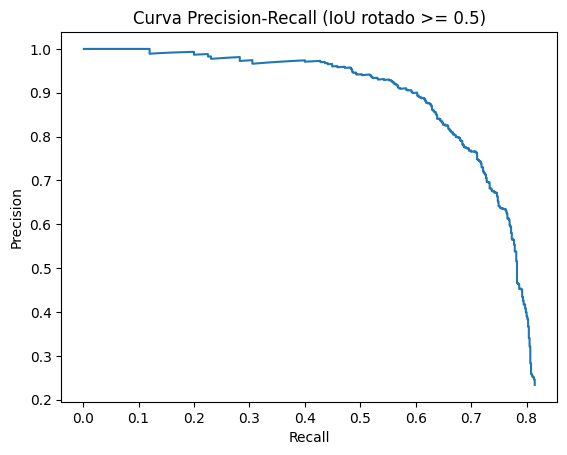

In [31]:
plt.figure()
plt.plot(recall_curve, precision_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (IoU rotado >= 0.5)")
plt.show()

La curva Precision-Recall muestra que el ensamble mantiene una precisión alta mientras el recall aumenta hasta un nivel medio. A partir de cierto punto, para ganar más recall la precisión cae con fuerza, lo que indica que bajar demasiado el umbral incrementa falsos positivos. Un umbral razonable suele estar cerca del “codo” de la curva, antes de esa caída.

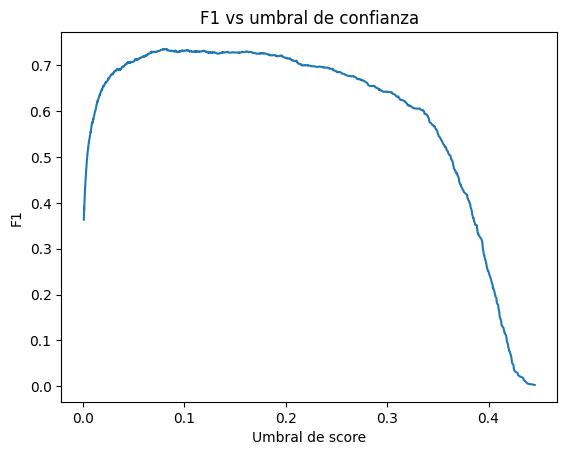

0.07927126437425613

In [32]:
plt.figure()
plt.plot(scores_sorted, f1_curve)
plt.xlabel("Umbral de score")
plt.ylabel("F1")
plt.title("F1 vs umbral de confianza")
plt.show()

best_thr

El gráfico muestra que el mejor equilibrio entre precisión y recall se logra con un umbral de score bajo, alrededor de 0.08. Si el umbral se sube demasiado, el F1 cae porque el modelo deja de detectar muchos miotubos (baja el recall). Si el umbral se baja demasiado, también cae el F1 porque aparecen más falsos positivos.

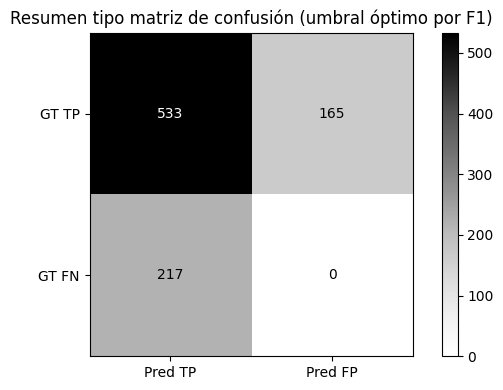

In [36]:
mat = np.array([[best_tp, best_fp],
                [best_fn, 0]], dtype=np.int64)

plt.figure(figsize=(6, 4))
plt.imshow(mat, cmap="Greys", interpolation="nearest")

plt.xticks([0, 1], ["Pred TP", "Pred FP"])
plt.yticks([0, 1], ["GT TP", "GT FN"])
plt.title("Resumen tipo matriz de confusión (umbral óptimo por F1)")

vmax = mat.max() if mat.max() > 0 else 1
th = vmax * 0.5

for i in range(2):
    for j in range(2):
        val = mat[i, j]
        color = "white" if val > th else "black"
        plt.text(j, i, f"{val}", ha="center", va="center", color=color)

plt.colorbar()
plt.tight_layout()
plt.show()

Con el umbral óptimo por F1, el modelo detecta correctamente 533 miotubos etiquetados, pero aún genera 165 falsos positivos y deja pasar 217 miotubos (falsos negativos). En un escenario de pseudo-labeling, parte de esos “falsos positivos” pueden ser miotubos reales no anotados.

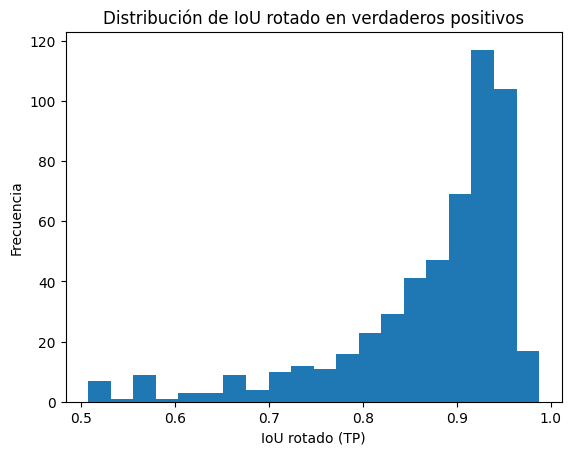

In [34]:
keep_mask = scores_all >= best_thr
tp_keep = tp_all & keep_mask
ious_tp = miou_all[tp_keep]
ious_tp = ious_tp[~np.isnan(ious_tp)]

plt.figure()
plt.hist(ious_tp, bins=20)
plt.xlabel("IoU rotado (TP)")
plt.ylabel("Frecuencia")
plt.title("Distribución de IoU rotado en verdaderos positivos")
plt.show()

La distribución está concentrada en valores altos (muchos verdaderos positivos caen entre 0.85 y 0.95), lo que indica que cuando el ensamble detecta un miotubo, normalmente también lo localiza bien con una caja rotada ajustada. La cola hacia valores cercanos a 0.5 sugiere que todavía hay casos difíciles donde la detección es correcta, pero la orientación o el ajuste de la caja no es tan preciso.